![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 11 - RNN </center>
### <center> Vanilla RNN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/11_RNN/MainVanillaRNN_Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchsummary

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/10_RNN/DeepLearningFramework ./DeepLearningFramework

#### Dataset:

In [4]:
#-- A simple sequence dataset:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, lX, vY):
        self.lX = lX
        self.vY = vY
        
    def __len__(self):
        return len(self.lX)
    
    def __getitem__(self, idx):
        vXi = self.lX[idx]
        yi  = self.vY[idx]
        return vXi, yi

In [5]:
from torch.nn.utils.rnn import pack_sequence

def SequenceCollateFunction(lBatch):
    
    lX, lY = zip          (*lBatch)
    vY     = torch.stack  (lY)
    mPackX = pack_sequence(lX, enforce_sorted=False)
    
    return mPackX, vY

### Exercise
* The goal is to estimate the following function:
![f_x](https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_RNN//f_x.png?raw=true)
* Train an RNN model and get $R^2$ above `0.99`.

#### Generate data:

In [6]:
minL   = 5
maxL   = 30
nTrain = 50000
nTest  = 10000
N      = nTrain + nTest

vY = torch.zeros(N)
lX = [None] * N
for ii in range(N):
    L       = np.random.randint(minL, maxL)
    vX      = torch.rand(L, 1)
    idx     = np.random.randint(L)
    vX[idx] = -1
    lX[ii]  = vX
    vY[ii]  = torch.sum(vX[:idx]**2) - torch.sum(vX[idx+1:]**2)

In [7]:
from torch.utils.data import random_split

oDataset            = SequenceDataset(lX, vY.float())
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest])

len(oTrainSet), len(oTestSet)

(50000, 10000)

In [8]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=SequenceCollateFunction)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=SequenceCollateFunction)

### Model:

In [9]:
class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__() #-- always do this
        
        H         = 100
        self.oRnn = nn.RNN   (input_size=1, hidden_size=H, batch_first=True)
        self.oFC  = nn.Linear(H, 1)

    def forward(self, mPackX):
                                   #-- mPackX.shape = (N*T,)
        _, mH  = self.oRnn(mPackX) #-- mH    .shape = (1, N, H)
        vY     = self.oFC (mH[0])  #-- vY    .shape = (N, 1)
        
        return vY[:,0]
#-------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
mPack, vY = next(iter(oTrainDL))

RnnModel()(mPack).shape

torch.Size([128])

In [10]:
from DeepLearningFramework.Metric import R2Score

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.MSELoss()
Metric = R2Score

In [11]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel

nEpochs    = 30
nIter      = nEpochs * len(oTrainDL)

oModel     = RnnModel  ().to(DEVICE)
oOptim     = optim.Adam(oModel.parameters(), lr=5e-5, betas=(0.8, 0.9))
oScheduler = OneCycleLR(oOptim, max_lr=5e-3, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler);

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss: 10.648 | Val loss:  6.728 | Train Metric:  0.239 | Val Metric:  0.514 | epoch time:  1.945 | <-- Checkpoint!
Epoch 001: | Train loss:  5.958 | Val loss:  5.411 | Train Metric:  0.573 | Val Metric:  0.607 | epoch time:  1.385 | <-- Checkpoint!
Epoch 002: | Train loss:  5.036 | Val loss:  5.256 | Train Metric:  0.639 | Val Metric:  0.620 | epoch time:  1.381 | <-- Checkpoint!
Epoch 003: | Train loss:  4.804 | Val loss:  4.626 | Train Metric:  0.655 | Val Metric:  0.666 | epoch time:  1.388 | <-- Checkpoint!
Epoch 004: | Train loss:  2.257 | Val loss:  1.183 | Train Metric:  0.837 | Val Metric:  0.914 | epoch time:  1.407 | <-- Checkpoint!
Epoch 005: | Train loss:  0.874 | Val loss:  1.108 | Train Metric:  0.937 | Val Metric:  0.919 | epoch time:  1.413 | <-- Checkpoint!
Epoch 006: | Train loss:  0.637 | Val loss:  0.974 | Train Metric:  0.954 |

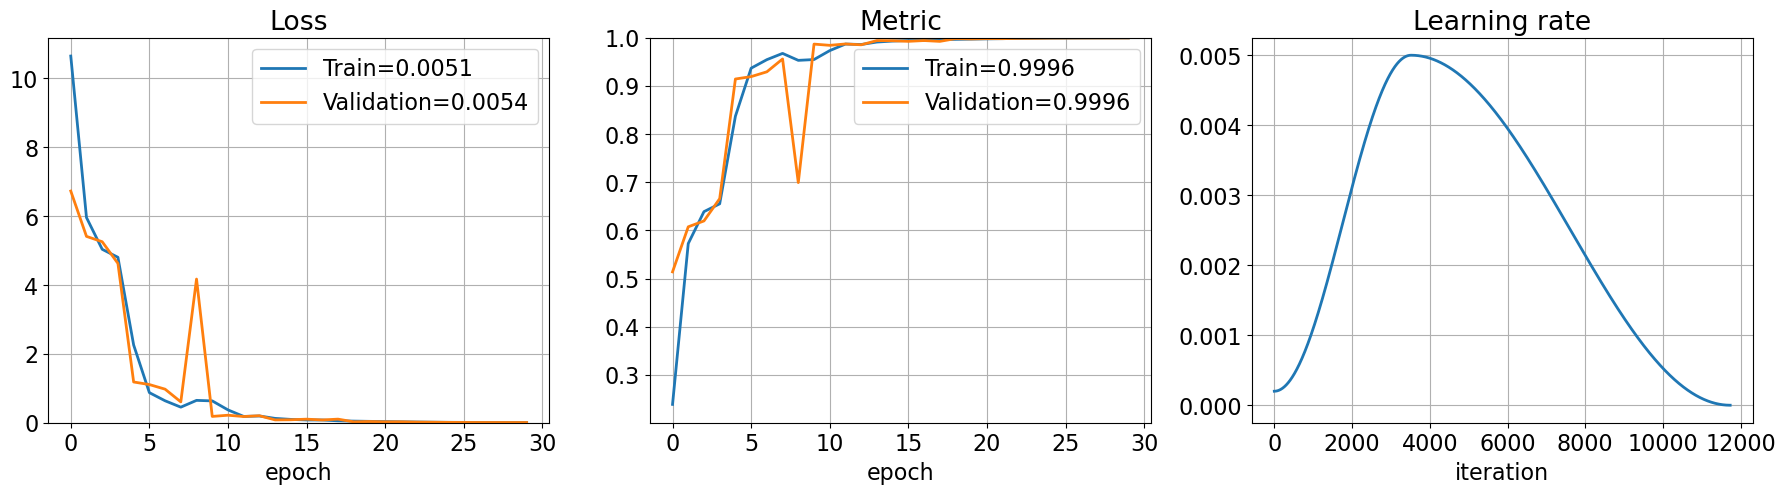

In [12]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()